#Computer Vision Lab

##Fine-tune pretrained models

In [ ]:
%matplotlib inline

In [ ]:
# Libraries used
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  # interactive mode

# check for gpu ,it should be enabled from the menu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [ ]:

from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/Transfer learning'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/Transfer learning


In [ ]:
BATCH_SIZE = 32

# use for crossentropy classification because the output is a vector of probabilities that hardly can be compared with the target vector of labels when one-hot encoded makes these integers from 0 to 14 (15 classes)
LABEL_SMOOTHING = 0.015

In [ ]:
# Data augmentation for

# The mean and std   are taken from the ImageNet dataset
mean_images = [0.485, 0.456, 0.406]
std_images = [0.229, 0.224, 0.225]


data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(size=(512, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean_images), torch.Tensor(std_images)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(512),
            transforms.CenterCrop(
                size=(512, 512)
            ),  # image size same as all ove the net
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean_images), torch.Tensor(std_images)),
        ]
    ),
}

In [ ]:
trainset = datasets.Food101(
    "./data_Food101",
    split="train",
    transform=data_transforms,
    target_transform=None,
    download=False,
)
testset = datasets.Food101(
    "./data_Food101",
    split="test",
    transform=data_transforms,
    target_transform=None,
    download=False,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [ ]:
print(type(trainloader.dataset))
dataloaders = {}
dataloaders["train"] = trainloader
dataloaders["val"] = testloader
dataset_sizes = {}
dataset_sizes["train"] = len(trainloader)
dataset_sizes["val"] = len(testloader)

<class 'torchvision.datasets.food101.Food101'>


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        #  training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # scheduler.step()
                model.train()  #  training mode
            else:
                model.eval()  #  evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # get best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history

In [ ]:
def show_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit for render


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                show_image(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Finetuning the model net

In [ ]:
model_res = models.resnet18(pretrained=True)
num_features = model_res.fc.in_features
num_classes = 2  # the know predicted classes
model_res.fc = nn.Linear(num_features, num_classes)

model_ft = model_res.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# All parameters are being optimized
optimizer_ft = optim.SGD(
    model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003
)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\androgo/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.09MB/s]


In [ ]:
number_epochs = 29
model_ft, val_acc_history1 = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=number_epochs
)

In [ ]:
def plot_accuracy(val_acc_history):
    shist = [val.cpu().numpy() for val in val_acc_history]

    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1, number_epochs + 1), shist, label="Pretrained")
    plt.ylim((0, 1.0))
    plt.xticks(np.arange(1, number_epochs + 1, 1.0))
    plt.legend()
    plt.show()
    print(max(shist))

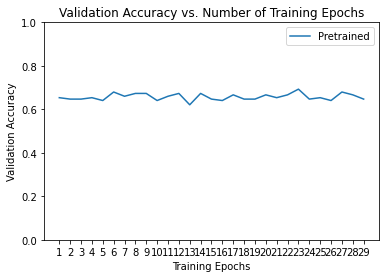

0.6928104575163399


In [ ]:
plot_accuracy(val_acc_history1)

In [ ]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary

summary(model_ft, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


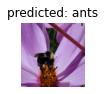

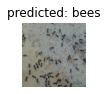

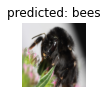

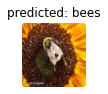

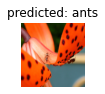

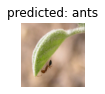

In [ ]:
visualize_model(model_ft)

#Freezing the weights


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
# freeze the weights
for param in model_conv.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True so these are trained
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=9, gamma=0.1)

In [ ]:
model_conv, val_acc_history2 = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=number_epochs
)

Epoch 0/28
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7046 Acc: 0.5615
val Loss: 0.6854 Acc: 0.5752

Epoch 1/28
----------
train Loss: 0.6778 Acc: 0.5820
val Loss: 0.6734 Acc: 0.6340

Epoch 2/28
----------
train Loss: 0.6854 Acc: 0.5656
val Loss: 0.6883 Acc: 0.6013

Epoch 3/28
----------
train Loss: 0.6856 Acc: 0.5656
val Loss: 0.6676 Acc: 0.6078

Epoch 4/28
----------
train Loss: 0.6802 Acc: 0.5984
val Loss: 0.6626 Acc: 0.6013

Epoch 5/28
----------
train Loss: 0.6840 Acc: 0.5615
val Loss: 0.6799 Acc: 0.5882

Epoch 6/28
----------
train Loss: 0.6782 Acc: 0.5779
val Loss: 0.6821 Acc: 0.5817

Epoch 7/28
----------
train Loss: 0.6698 Acc: 0.5984
val Loss: 0.6862 Acc: 0.5882

Epoch 8/28
----------
train Loss: 0.6968 Acc: 0.5492
val Loss: 0.6745 Acc: 0.6275

Epoch 9/28
----------
train Loss: 0.6888 Acc: 0.5697
val Loss: 0.6881 Acc: 0.6013

Epoch 10/28
----------
train Loss: 0.6778 Acc: 0.5697
val Loss: 0.6886 Acc: 0.5948

Epoch 11/28
----------
train Loss: 0.6863 Acc: 0.5656
val Loss: 0.6796 Acc: 0.5752

Epoch 12/28
----------
t

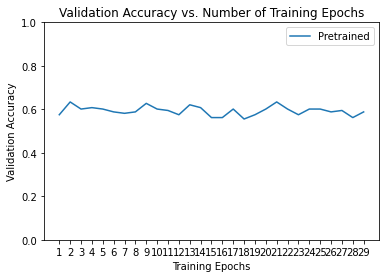

0.6339869281045751


In [ ]:
plot_accuracy(val_acc_history2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


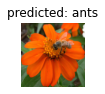

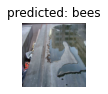

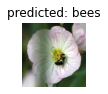

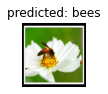

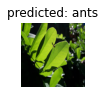

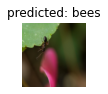

In [ ]:
visualize_model(model_conv)